# レーティング

In [1]:
import numpyro
import numpyro.distributions as dist

import arviz as az

import jax
import jax.numpy as jnp

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(3)

In [7]:
# data
data = pd.read_csv('./data/Ud_4/data.csv')
data['total'] = data['wins'] + data['loses']
data

,team_a,team_b,wins,loses,total
0,Tigers,Giants,5,4,9
1,Tigers,Swallows,7,1,8
2,Tigers,Dragons,4,3,7
3,Tigers,Carp,5,2,7
4,Tigers,DeNA,7,2,9
5,Giants,Swallows,4,2,6
6,Giants,Dragons,5,4,9
7,Giants,Carp,5,5,10
8,Giants,DeNA,5,0,5
9,Swallows,Dragons,5,1,6


In [8]:
data_flipped = data[['team_b', 'team_a', 'loses', 'wins', 'total']]
data_flipped.columns = ['team_a', 'team_b', 'wins', 'loses', 'total']
data_flipped

,team_a,team_b,wins,loses,total
0,Giants,Tigers,4,5,9
1,Swallows,Tigers,1,7,8
2,Dragons,Tigers,3,4,7
3,Carp,Tigers,2,5,7
4,DeNA,Tigers,2,7,9
5,Swallows,Giants,2,4,6
6,Dragons,Giants,4,5,9
7,Carp,Giants,5,5,10
8,DeNA,Giants,0,5,5
9,Dragons,Swallows,1,5,6


In [9]:
data_full = pd.concat([data, data_flipped])

In [10]:
df = data_full.groupby('team_a').sum()

df['rate'] = df['wins'] / (df['total'])

df = df.sort_values('rate', ascending=False)
df.index.name = 'team'
df

,wins,loses,total,rate
team,,,,
Tigers,28,12,40,0.700000
Giants,23,16,39,0.589744
Swallows,20,16,36,0.555556
Carp,16,20,36,0.444444
Dragons,16,22,38,0.421053
DeNA,12,29,41,0.292683


In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
all_teams = data_full['team_a'].unique()
print(all_teams)

['Tigers' 'Giants' 'Swallows' 'Dragons' 'Carp' 'DeNA']


In [15]:
encoder = LabelEncoder()
encoder = encoder.fit(all_teams)

In [16]:
encoder.classes_

array(['Carp', 'DeNA', 'Dragons', 'Giants', 'Swallows', 'Tigers'],
      dtype=object)

In [21]:
num_teams = len(all_teams)

id_a = encoder.transform(data['team_a'])
id_b = encoder.transform(data['team_b'])

wins = jnp.array(data["wins"].values)
loses = jnp.array(data["loses"].values)
total = jnp.array(data["total"].values)

id_a = jnp.array(id_a)
id_b = jnp.array(id_b)

# モデリング

各球団の”強さ”をガウス分布でモデル化
$$
r_i \sim \mathcal{N}(r_i|\mu, \sigma)
$$
強さの差をシグモイド関数で0~1に正規化した値を平均パラメータ$\theta$とした二項分布から
i番目とj番目のチームがM回戦ったときの勝敗が生成されるとする
$$
\theta_{i,j} = sigmoid(r_i - r_j) \\
y \sim Bin(y|M, \theta_{i,j})
$$
よって全ての対戦組み合わせの数を$N$,勝数を$Y \in R^N$とすると
$$
p(Y,\Theta) = p(\Theta) \prod_{n=1}^N Bin(y_n|M_n, \theta_n)
$$

In [48]:
def model(id_a, id_b, num_teams, total, wins=None):
    
    num_data = len(total)
    
    s = numpyro.sample("s", dist.HalfNormal(10)) #分散パラの事前分布
    r = numpyro.sample("r", dist.Normal(0, s), sample_shape=(num_teams,))#強さの変数の分布
    
    theta = jax.nn.sigmoid(r[id_a] - r[id_b])
    
    with numpyro.plate("data", num_data): #尤度
        numpyro.sample("obs", dist.Binomial(total_count=total, probs=theta), obs=wins)

In [49]:
nuts = numpyro.infer.NUTS(model, target_accept_prob=0.99)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=3)

mcmc.run(jax.random.PRNGKey(0), id_a, id_b, num_teams, total, wins=wins)
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

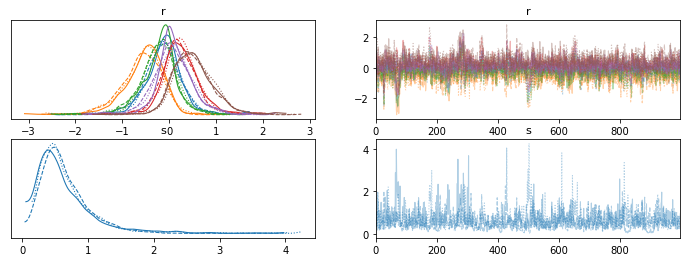

In [25]:
az.plot_trace(idata);

In [26]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r[0],-0.131,0.428,-0.941,0.662,0.019,0.015,592.0,531.0,1.00
r[1],-0.561,0.451,-1.425,0.180,0.021,0.016,547.0,583.0,1.01
r[2],-0.221,0.419,-1.076,0.508,0.018,0.014,621.0,648.0,1.00
r[3],0.240,0.412,-0.488,1.002,0.019,0.015,607.0,517.0,1.00
r[4],0.100,0.420,-0.642,0.950,0.020,0.016,536.0,582.0,1.01
r[5],0.517,0.446,-0.236,1.355,0.020,0.016,559.0,604.0,1.00
s,0.644,0.426,0.053,1.345,0.020,0.014,410.0,382.0,1.00


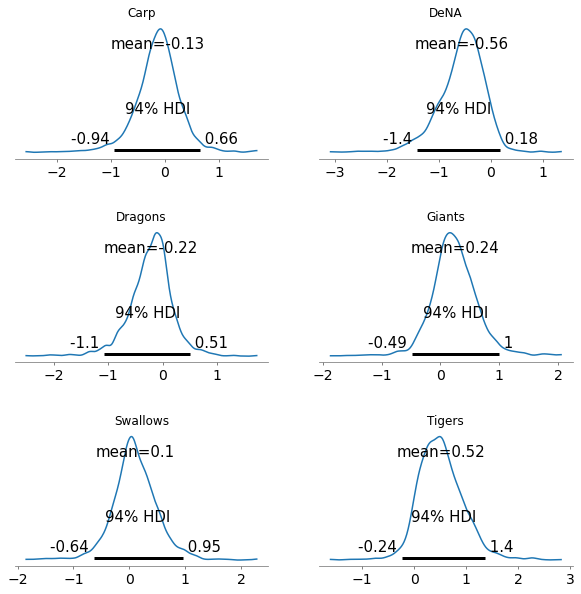

In [28]:
# チームの強さ
fig = plt.figure(figsize=(10,10))

for k in range(6):
    ax = fig.add_subplot(3, 2, k+1)
    az.plot_posterior(idata.posterior["r"][:,:,k], ax = ax)
    ax.set_title(encoder.classes_[k])
fig.subplots_adjust(hspace=0.5)

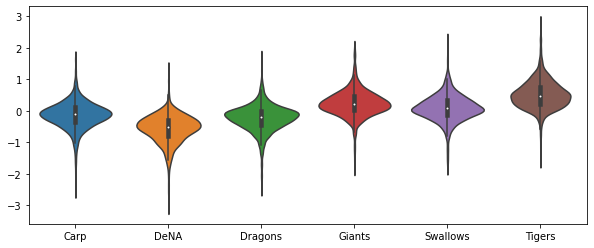

In [31]:
fig = plt.figure(figsize=(10, 4))

ax = sns.violinplot(data=mcmc_samples["r"], fig=fig)
ax.set_xticklabels(encoder.classes_);

In [32]:
id_tigers = encoder.transform(["Tigers"])[0]
id_giants = encoder.transform(["Giants"])[0]
id_swallows = encoder.transform(["Swallows"])[0]

r = idata.posterior["r"] #shape=[chain, sample, dim of valiavle]

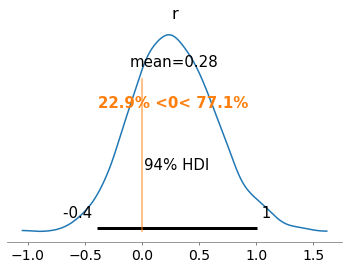

In [34]:
# 虎vs巨　比較
az.plot_posterior(r[:,:,id_tigers] - r[:,:,id_giants], ref_val=0);

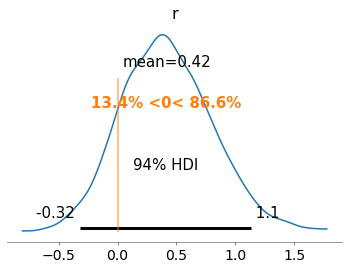

In [37]:
# 虎vs燕　比較
az.plot_posterior(r[:,:,id_tigers] - r[:,:,id_swallows], ref_val=0);

In [38]:
# 新たにサンプリング

predictive = numpyro.infer.Predictive(model, mcmc_samples)
ppc_samples = predictive(jax.random.PRNGKey(1), id_a, id_b, num_teams, total)

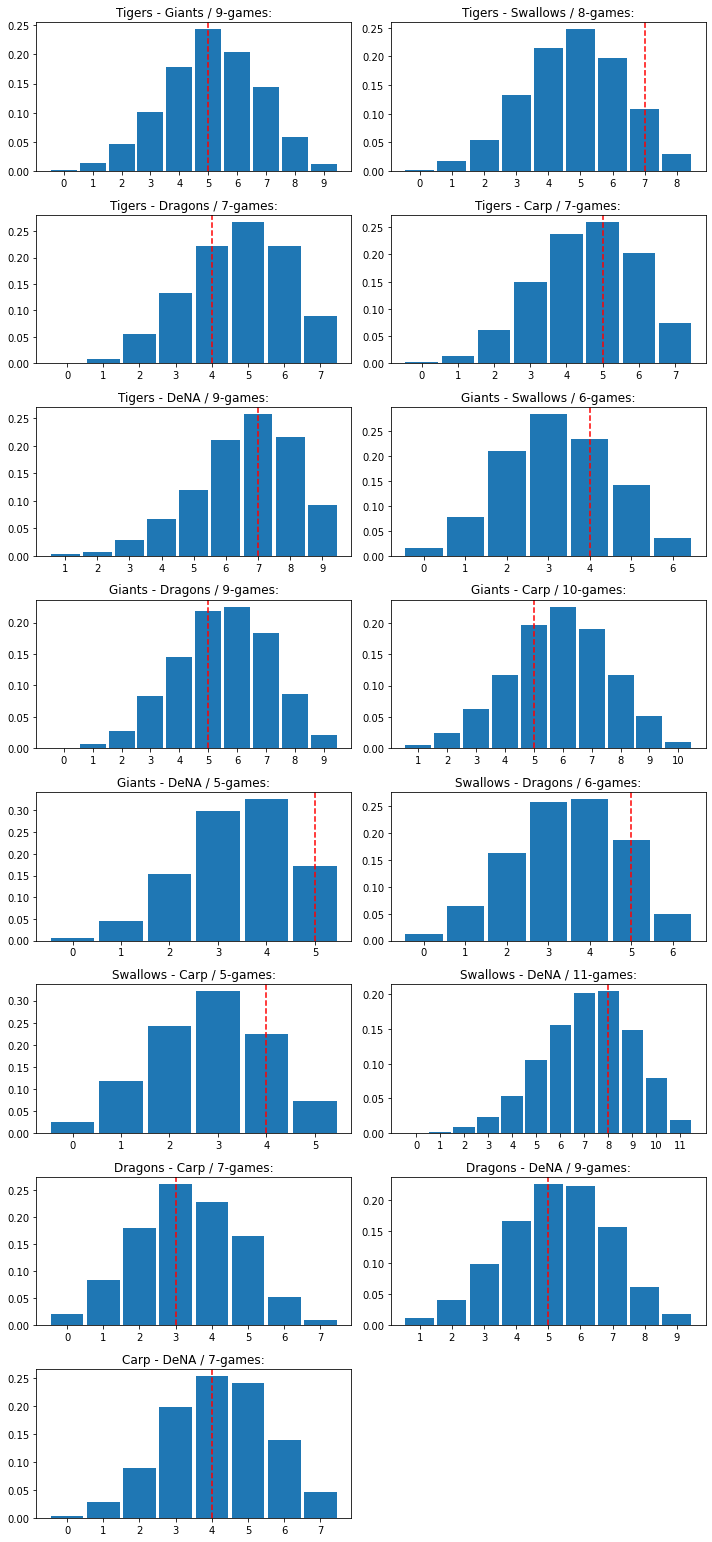

In [39]:
fig = plt.figure(figsize=(10, 40))

for k in range(15):
    ax = fig.add_subplot(15, 2, k+1)
    
    az.plot_dist(ppc_samples["obs"][:,k])
    ax.axvline(wins[k], color="r", linestyle="dashed")
    
    str_title = "{} - {} / {}-games:".format(data.iloc[k]["team_a"], data.iloc[k]["team_b"],total[k])
    
    ax.set_title(str_title)
    
plt.tight_layout()

In [41]:
# その後の試合を考察
data_new = pd.read_csv("./data/Ud_4/data_new.csv")

,team_a,team_b,wins,loses
0,Tigers,Giants,7,8
1,Tigers,Swallows,10,3
2,Tigers,Dragons,7,6
3,Tigers,Carp,8,5
4,Tigers,DeNA,11,9
5,Giants,Swallows,8,5
6,Giants,Dragons,9,6
7,Giants,Carp,9,6
8,Giants,DeNA,8,3
9,Swallows,Dragons,10,2


In [42]:
data_merged = pd.merge(data, data_new, on=["team_a", "team_b"])
data_merged

,team_a,team_b,wins_x,loses_x,total,wins_y,loses_y
0,Tigers,Giants,5,4,9,7,8
1,Tigers,Swallows,7,1,8,10,3
2,Tigers,Dragons,4,3,7,7,6
3,Tigers,Carp,5,2,7,8,5
4,Tigers,DeNA,7,2,9,11,9
5,Giants,Swallows,4,2,6,8,5
6,Giants,Dragons,5,4,9,9,6
7,Giants,Carp,5,5,10,9,6
8,Giants,DeNA,5,0,5,8,3
9,Swallows,Dragons,5,1,6,10,2


In [43]:
wins_new = data_merged["wins_y"].values - data_merged["wins_x"].values
loses_new = data_merged["loses_y"].values - data_merged["loses_x"].values

total_new = wins_new + loses_new

In [44]:
predicive = numpyro.infer.Predictive(model, mcmc_samples)

ppc_samples = predicive(jax.random.PRNGKey(1), id_a, id_b, num_teams, total_new)

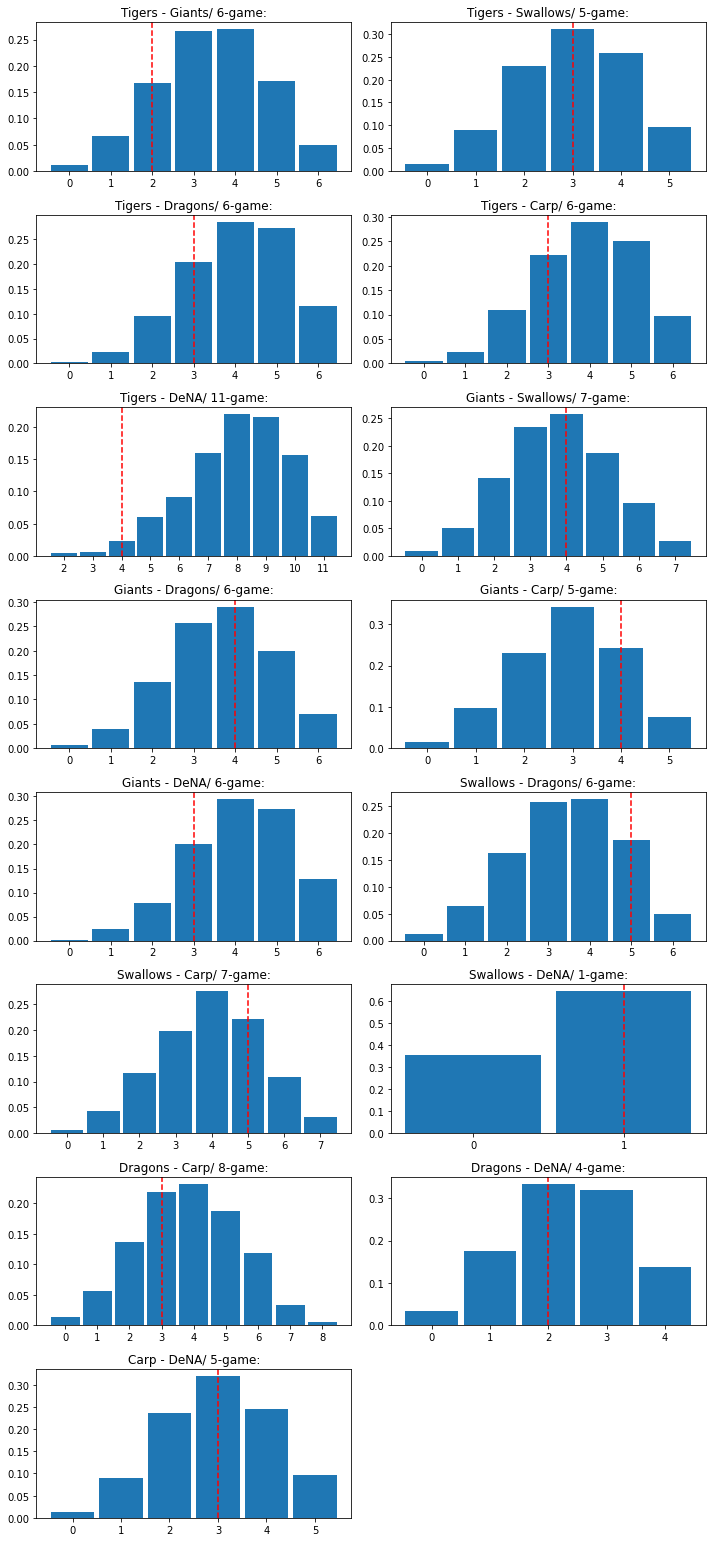

In [46]:
fig = plt.figure(figsize=(10, 40))

for k in range(15):
    ax = fig.add_subplot(15, 2, k+1)
    
    az.plot_dist(ppc_samples["obs"][:, k])
    ax.axvline(wins_new[k], color="r", linestyle="dashed")
    str_title = "{} - {}/ {}-game:".format(data.iloc[k]["team_a"], data.iloc[k]["team_b"], total_new[k])
    
    ax.set_title(str_title)
plt.tight_layout()

DeviceArray([ 9,  8,  7,  7,  9,  6,  9, 10,  5,  6,  5, 11,  7,  9,  7], dtype=int32)